***IMAGE COMPRESSION USING FAST FOURIER TRANSFORM***

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import cv2
from sklearn import metrics

**Hand made FFT**          (Only accepts powerof2 sized data sets)

In [2]:
def oneDimFFT(data):
    output = np.zeros_like(data, dtype=complex)
    if len(data) == 2:
        output[0] = data[0] + data[1]
        output[1] = data[0] - data[1]

    else:
        N = len(data)
        evenIndex = data[::2]
        oddIndex = data[1::2]
        E = oneDimFFT(evenIndex)
        O = oneDimFFT(oddIndex)
        for k in range(N//2):
            W = np.exp(-2j * np.pi * k / N)
            output[k] = E[k] + O[k] * W
            output[k + N//2] = E[k] - O[k] * W
        
    return output


**IFFT * size of data**

In [3]:
def inverseOneDimFFT(data):
    output = np.zeros_like(data, dtype=complex)
    if len(data) == 2:
        output[0] = data[0] + data[1]
        output[1] = data[0] - data[1]

    else:
        N = len(data)
        evenIndex = data[::2]
        oddIndex = data[1::2]
        E = inverseOneDimFFT(evenIndex)
        O = inverseOneDimFFT(oddIndex)
        for k in range(N//2):
            W = np.exp(2j * np.pi * k / N)
            output[k] = E[k] + O[k] * W
            output[k + N//2] = E[k] - O[k] * W
        
    return output


**2D FFT**

In [4]:
def twoDimFFT (data):
    dataprime = np.zeros_like(data, dtype = complex)
    M, N = data.shape
    for i in range(M):
        dataprime[i] = oneDimFFT(data[i])

    output = np.zeros_like(data, dtype = complex)
    dataprimeTransposed = dataprime.T
    for j in range(N):
        output[:, j] = oneDimFFT(dataprimeTransposed[j])

    return output

**2D IFFT**

In [5]:
def inverseTwoDimFFT (data):
    dataprime = np.zeros_like(data, dtype = complex)
    M, N = data.shape
    for i in range(M):
        dataprime[i] = inverseOneDimFFT(data[i]) / N

    output = np.zeros_like(data, dtype = complex)
    dataprimeTransposed = dataprime.T
    for j in range(N):
        output[:, j] = inverseOneDimFFT(dataprimeTransposed[j]) / M

    return output

**TestingUsingRealPictures**

In [6]:
def load_grayscale_image(path, width, height):
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE) / 255.0
    image = cv2.resize(image, dsize=(width, height), interpolation=cv2.INTER_CUBIC)
    return image

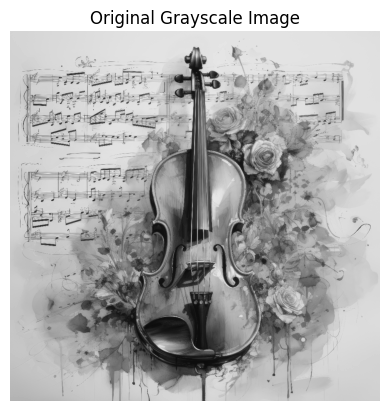

In [7]:
image = load_grayscale_image('violin.jpg', 1024, 1024)


plt.imshow(image, cmap='gray')
plt.title('Original Grayscale Image')
plt.axis('off')

plt.show()

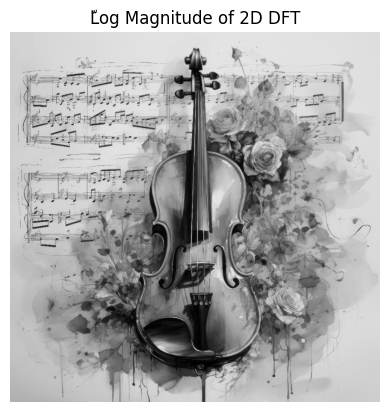

In [8]:
F = twoDimFFT(image)
recon = inverseTwoDimFFT(F)

plt.imshow(np.abs(recon), cmap='gray')
plt.title('ّLog Magnitude of 2D DFT')
plt.axis('off')
plt.show()

**Testing compression**

In [9]:
def compress_image(F, fraction):
    rows, cols = F.shape
    compressed_F = np.zeros((rows, cols), dtype = complex)

    frow = int((fraction * rows) / 2)
    fcol = int((fraction * cols) / 2)

    compressed_F[:frow, :fcol] = F[:frow, :fcol]
    compressed_F[rows - frow:, cols - fcol:] = F[rows - frow:, cols - fcol:]
    compressed_F[:frow, cols - fcol:] = F[:frow, cols - fcol:]
    compressed_F[rows - frow:, :fcol] = F[rows - frow:, :fcol]
    

    return compressed_F

**Testing if compression works or not**

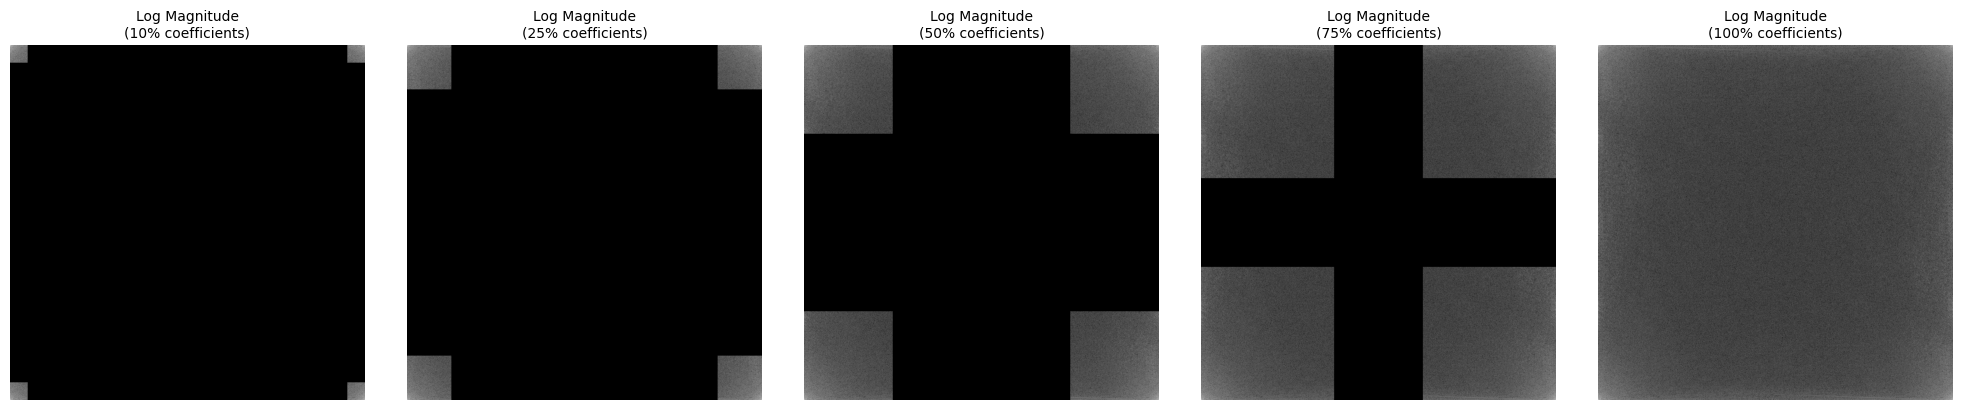

In [12]:
fractions = [0.1, 0.25, 0.5, 0.75, 1]
fig, axes = plt.subplots(1, len(fractions), figsize=(20, 4))

for i, (frac, ax) in enumerate(zip(fractions, axes)):
    compressed_F = compress_image(F, frac)
    log_magnitude_dft = np.log(1 + np.abs(compressed_F))
    
    ax.imshow(log_magnitude_dft, cmap='gray')
    ax.set_title(f'Log Magnitude\n({frac * 100:.0f}% coefficients)', fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

Loss (1% coefficients):
24055.285945704454
Loss (5% coefficients):
12568.506533340274
Loss (10% coefficients):
9164.619079611684
Loss (25% coefficients):
5173.842228125368
Loss (50% coefficients):
3074.285033360461
Loss (75% coefficients):
1509.7864761835783
Loss (100% coefficients):
0.0


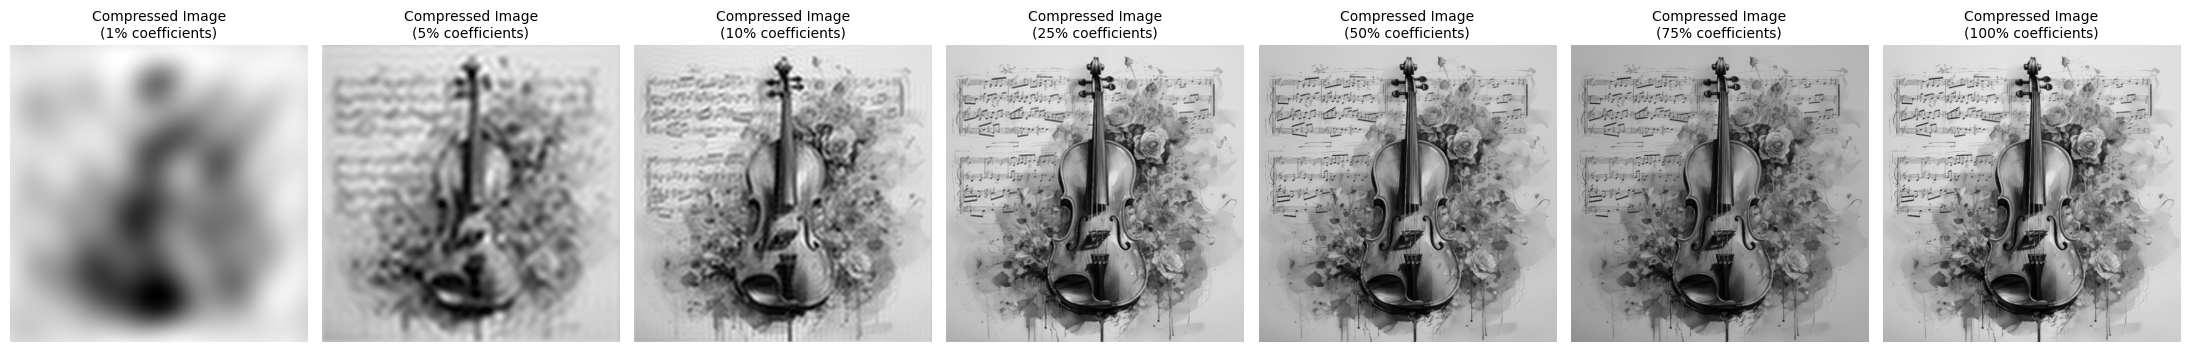

In [13]:
fractions = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1]
fig, axes = plt.subplots(1, len(fractions), figsize=(22, 4)) 

for ax, frac in zip(axes, fractions):
    compressed_F = compress_image(F, frac)
    reconstructed_image = np.abs(inverseTwoDimFFT(compressed_F))

    ax.imshow(reconstructed_image, cmap='gray')
    ax.set_title(f'Compressed Image\n({frac * 100:.0f}% coefficients)', fontsize=10)
    ax.axis('off')

    print(f"Loss ({frac * 100:.0f}% coefficients):")
    print(metrics.mean_squared_error(np.abs(F), np.abs(compressed_F)))

plt.tight_layout()
plt.show()